###0. 데이터셋 다운로드 및 분할(train/val/test)

원본 데이터셋 Google Drive에서 불러오기
- kr3_filtered_utf8.csv
- kr3_sentence_label(add).csv

gdown 라이브러리 설치
(주의! '!' 문법은 ipynb 파일에서만 작동)

In [ ]:
!pip install -q gdown transformers torch pandas numpy matplotlib seaborn scikit-learn

In [ ]:
import os
import gdown

kr3_filtered_utf8.csv

In [ ]:
# https://drive.google.com/file/d/1hEqeVe_7eOytxLVUw1O2Rb-M0G0j_zSo/view?usp=sharing
test_file_id = '1hEqeVe_7eOytxLVUw1O2Rb-M0G0j_zSo'
test_url = f'https://drive.google.com/uc?id={test_file_id}'
test_output = 'kr3_filtered_utf8.csv'

if not os.path.exists(test_output):
    print(f"Downloading {test_output} from Google Drive...")
    try:
        gdown.download(test_url, test_output, quiet=False)
        print(f"{test_output} 다운로드 완료.")
    except Exception as e:
        print(f"{test_output} 다운로드 실패: {e}")
else:
    print(f"ℹ{test_output} 파일이 이미 존재합니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1hEqeVe_7eOytxLVUw1O2Rb-M0G0j_zSo
From (redirected): https://drive.google.com/uc?id=1hEqeVe_7eOytxLVUw1O2Rb-M0G0j_zSo&confirm=t&uuid=2a697f87-1bcc-4cf8-b4b4-82a6d77f4249
To: /content/kr3_filtered_utf8.csv
100%|██████████| 198M/198M [00:03<00:00, 63.8MB/s]

kr3_filtered_utf8.csv 다운로드 완료.


kr3_sentence_label(add).csv

In [ ]:
# https://drive.google.com/file/d/1GS-dPWviShlEqv4B3IJc9_3j9nOqfJGy/view?usp=sharing
test_file_id = '1GS-dPWviShlEqv4B3IJc9_3j9nOqfJGy'
test_url = f'https://drive.google.com/uc?id={test_file_id}'
test_output = 'kr3_sentence_label(add).csv'

if not os.path.exists(test_output):
    print(f"Downloading {test_output} from Google Drive...")
    try:
        gdown.download(test_url, test_output, quiet=False)
        print(f"{test_output} 다운로드 완료.")
    except Exception as e:
        print(f"{test_output} 다운로드 실패: {e}")
else:
    print(f"ℹ{test_output} 파일이 이미 존재합니다.")

Downloading...
From: https://drive.google.com/uc?id=1GS-dPWviShlEqv4B3IJc9_3j9nOqfJGy
To: /content/kr3_sentence_label(add).csv
100%|██████████| 131k/131k [00:00<00:00, 63.8MB/s]

kr3_sentence_label(add).csv 다운로드 완료.


데이터셋을 train/val/test으로 쪼갭니다.
- 같은 리뷰 내에서 나온 문장들은 그룹을 지어서 분할(Data leakage 방지)
- 각 데이터셋 별로 긍정/부정 라벨 비율 맞춤

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# 1. 데이터 로드 함수 정의 (Data Loading & Parsing)
def load_and_parse_csv(filepath):
    data = []
    print(f"Processing {filepath}...")

    if not os.path.exists(filepath):
        print(f"Error: File not found - {filepath}")
        return pd.DataFrame()

    with open(filepath, 'r', encoding='utf-8-sig', errors='replace') as f:
        lines = f.readlines()

    print(f"{len(lines):,} 줄 읽음. 파싱 시작...")

    for i, line in enumerate(lines):
        if i == 0: continue
        line = line.strip()
        if not line: continue

        parts = line.split(',')
        if len(parts) < 2: continue

        text = ""
        label = -1

        # Case 1: Text -> Label
        if parts[-1].strip() in ['0', '1']:
            label = int(parts[-1].strip())
            text = ",".join(parts[:-1]).strip().strip('"')

        # Case 2: Label -> Text
        elif parts[0].strip() in ['0', '1']:
            label = int(parts[0].strip())
            text = ",".join(parts[1:]).strip().strip('"')

        if label != -1 and len(text) > 1:
            data.append({'text': text, 'label': label})

    df = pd.DataFrame(data)
    df['id'] = df.index
    return df

# 2. 데이터 로드 및 전처리 (Load & Preprocessing)

# (1) Public Dataset Load
public_df = load_and_parse_csv("kr3_filtered_utf8.csv")

# (2) My Dataset Load
print("Loading My Dataset...")
try:
    my_df_raw = pd.read_csv("kr3_sentence_label(add).csv", encoding='utf-8-sig')

    # 컬럼 매핑: sentence_text -> text, sent_label -> label, review_id -> id
    if 'sentence_text' in my_df_raw.columns:
        my_df = my_df_raw[['sentence_text', 'sent_label', 'review_id']].copy()
        my_df.columns = ['text', 'label', 'id']
    else:
        print("My Data 컬럼 이름 확인 필요:", my_df_raw.columns)
        my_df = pd.DataFrame(columns=['text', 'label', 'id'])

except Exception as e:
    print(f"Error loading My Dataset: {e}")
    my_df = pd.DataFrame(columns=['text', 'label', 'id'])

# (3) 데이터 정제 (Label Filtering)
def clean_df(df):
    if df.empty: return df
    df['label'] = pd.to_numeric(df['label'], errors='coerce')
    df = df.dropna(subset=['text', 'label'])

    # 0(부정), 1(긍정) 라벨만 유지
    df = df[df['label'].isin([0, 1])]
    df['label'] = df['label'].astype(int)
    return df

public_df = clean_df(public_df)
my_df = clean_df(my_df)

print(f"전처리 완료 - Public: {len(public_df):,}개, My: {len(my_df):,}개")

# 3. 데이터 분할 (Stratified Group Split)
def stratified_group_split(df, id_col, label_col, test_size, val_size=None):
    if df.empty: return pd.DataFrame(), pd.DataFrame(), pd.DataFrame() if val_size else (pd.DataFrame(), pd.DataFrame())

    group_labels = df.groupby(id_col)[label_col].mean().round()
    unique_ids = group_labels.index.values
    unique_labels = group_labels.values

    train_ids, temp_ids = train_test_split(
        unique_ids, test_size=test_size, stratify=unique_labels, random_state=42
    )
    temp_labels = group_labels.loc[temp_ids].values

    if val_size:
        val_ids, test_ids = train_test_split(
            temp_ids, test_size=0.5, stratify=temp_labels, random_state=42
        )
        return (
            df[df[id_col].isin(train_ids)],
            df[df[id_col].isin(val_ids)],
            df[df[id_col].isin(test_ids)]
        )
    else:
        return df[df[id_col].isin(train_ids)], df[df[id_col].isin(temp_ids)]

# Public Data (80% : 10% : 10%)
print("Splitting Public Data...")
pub_train, pub_val, pub_test = stratified_group_split(public_df, 'id', 'label', test_size=0.2, val_size=True)

# My Data (60% : 20% : 20%)
print("Splitting My Data...")
my_train, my_val, my_test = stratified_group_split(my_df, 'id', 'label', test_size=0.4, val_size=True)

# 4. 병합 및 저장 (Save as TSV)
# CSV 파일은 리뷰 중간에 쉼표가 포함된 경우 오류가 나서, TSV로 저장
cols = ['text', 'label']

train_final = pd.concat([pub_train[cols], my_train[cols]]).sample(frac=1, random_state=42).reset_index(drop=True)
val_final = pd.concat([pub_val[cols], my_val[cols]]).sample(frac=1, random_state=42).reset_index(drop=True)
test_final = pd.concat([pub_test[cols], my_test[cols]]).sample(frac=1, random_state=42).reset_index(drop=True)

total_len = len(train_final) + len(val_final) + len(test_final)

print("-" * 60)
print(f"최종 데이터셋 (Total: {total_len:,} 개)")
print("-" * 60)

if total_len > 0:
    train_ratio = len(train_final) / total_len * 100
    val_ratio = len(val_final) / total_len * 100
    test_ratio = len(test_final) / total_len * 100

    print(f"Train : {len(train_final):>7,}개 ({train_ratio:.1f}%) | 긍정 비율: {train_final['label'].mean():.2f}")
    print(f"Val   : {len(val_final):>7,}개 ({val_ratio:.1f}%) | 긍정 비율: {val_final['label'].mean():.2f}")
    print(f"Test  : {len(test_final):>7,}개 ({test_ratio:.1f}%) | 긍정 비율: {test_final['label'].mean():.2f}")

    train_final.to_csv("train.tsv", index=False, sep='\t', encoding='utf-8-sig')
    val_final.to_csv("val.tsv", index=False, sep='\t', encoding='utf-8-sig')
    test_final.to_csv("test.tsv", index=False, sep='\t', encoding='utf-8-sig')
    print("데이터 저장 완료: train.tsv, val.tsv, test.tsv")
else:
    print("데이터가 없습니다.")

Processing kr3_filtered_utf8.csv...
641,389 줄 읽음. 파싱 시작...
Loading My Dataset...
전처리 완료 - Public: 458,631개, My: 1,193개
Splitting Public Data...
Splitting My Data...
------------------------------------------------------------
최종 데이터셋 (Total: 459,824 개)
------------------------------------------------------------
Train : 367,628개 (79.9%) | 긍정 비율: 0.85
Val   :  46,113개 (10.0%) | 긍정 비율: 0.84
Test  :  46,083개 (10.0%) | 긍정 비율: 0.84
데이터 저장 완료: train.tsv, val.tsv, test.tsv


###1. 데이터셋 및 데이터로더 정의

모델이 학습할 수 있도록 데이터를 토큰으로 변환하고, 배치 단위로 묶습니다.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import pandas as pd

# 1. 설정 (Hyperparameters)
MODEL_NAME = "beomi/kcbert-base"
MAX_LEN = 128     # 리뷰 문장 최대 길이(최대 128이 좋음)
BATCH_SIZE = 32   # 한 번에 학습할 데이터 양

# 2. 토크나이저 로드
print(f"Loading Tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 3. 커스텀 데이터셋 클래스 정의
class NaverReviewDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len):
        self.data = pd.read_csv(file_path, sep='\t', encoding='utf-8-sig')
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 데이터 한 줄 가져오기
        text = str(self.data.iloc[index]['text'])
        label = self.data.iloc[index]['label']

        # 토크나이징
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 4. 데이터셋 및 데이터로더 생성
print("Creating Datasets & DataLoaders...")

train_dataset = NaverReviewDataset("train.tsv", tokenizer, max_len=MAX_LEN)
val_dataset = NaverReviewDataset("val.tsv", tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"준비 완료.")
print(f"  - Train Dataset 개수: {len(train_dataset):,}")
print(f"  - Val Dataset 개수: {len(val_dataset):,}")

Loading Tokenizer: beomi/kcbert-base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Creating Datasets & DataLoaders...
준비 완료.
  - Train Dataset 개수: 367,628
  - Val Dataset 개수: 46,113


### 2. 모델 불러오기 및 설정

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# 1. GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}") # cuda로 나와야 GPU 연결

# 2. 모델 로드 (Pre-trained KcBERT)
print(f"Loading Model: {MODEL_NAME}...")

# num_labels=2 : 부정(0), 긍정(1)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# 3. 학습 파라미터 설정
epochs = 2

# 옵티마이저 (AdamW)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# 총 훈련 스텝 (배치 개수 X 에폭 수)
total_steps = len(train_loader) * epochs

# 스케줄러 (학습률을 서서히 줄여서 미세 조정)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"모델 세팅 완료! (총 {total_steps} Step 학습 예정)")

Using Device: cuda
Loading Model: beomi/kcbert-base...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 세팅 완료! (총 22978 Step 학습 예정)


###3. 모델 학습

모델을 저장할 Google Drive 마운트

In [ ]:
from google.colab import drive
import os

print("Google Drive 마운트 중...")
drive.mount('/content/drive')
print("구글 드라이브 마운트 완료")

Google Drive 마운트 중...
Mounted at /content/drive
구글 드라이브 마운트 완료


모델 학습 후 Google Drive에 저장

학습 시작! (총 2 Epochs)
   - Class Weight 적용됨: [5.699999809265137, 1.0] (부정 클래스 강화)

======== Epoch 1 / 2 ========
Training...
  Batch   100  of  11,489.    Elapsed: 0:01:00.    Train Loss: 0.2886    Train Acc: 0.9688
  Batch   200  of  11,489.    Elapsed: 0:02:00.    Train Loss: 0.2144    Train Acc: 0.8438
  Batch   300  of  11,489.    Elapsed: 0:03:00.    Train Loss: 0.5113    Train Acc: 0.9375
  Batch   400  of  11,489.    Elapsed: 0:04:00.    Train Loss: 0.0668    Train Acc: 0.9688
  Batch   500  of  11,489.    Elapsed: 0:05:00.    Train Loss: 0.1053    Train Acc: 0.9375
  Batch   600  of  11,489.    Elapsed: 0:06:00.    Train Loss: 0.0899    Train Acc: 1.0000
  Batch   700  of  11,489.    Elapsed: 0:06:59.    Train Loss: 0.0709    Train Acc: 0.9688
  Batch   800  of  11,489.    Elapsed: 0:07:59.    Train Loss: 0.2032    Train Acc: 0.9062
  Batch   900  of  11,489.    Elapsed: 0:08:59.    Train Loss: 0.1689    Train Acc: 0.9688
  Batch 1,000  of  11,489.    Elapsed: 0:09:59.    Train L

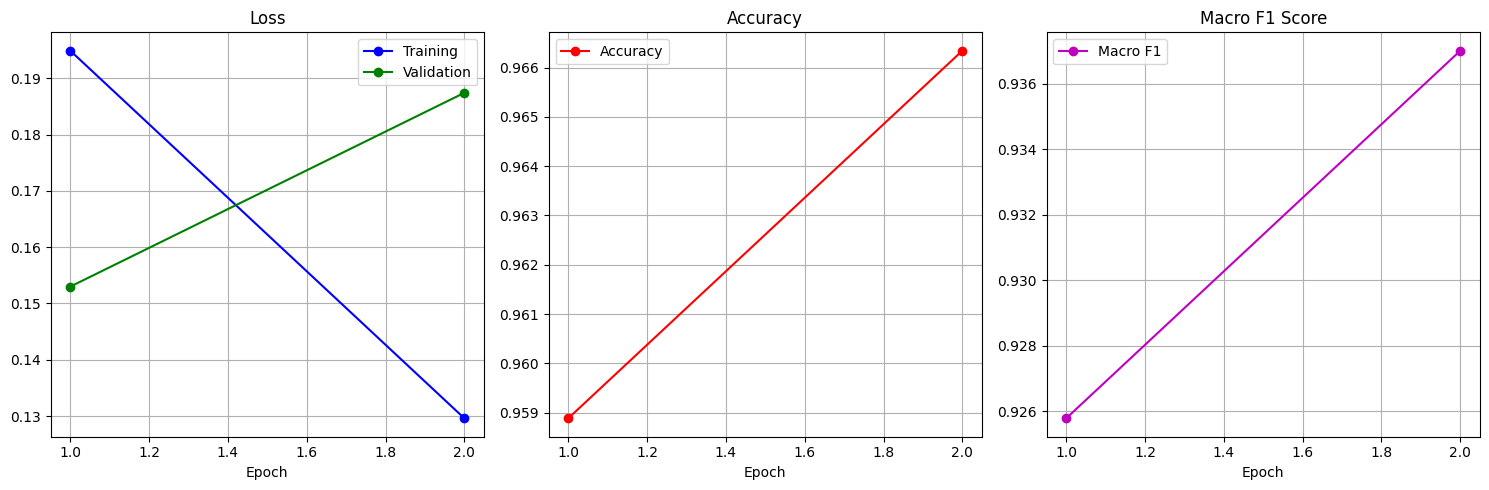


[Epoch별 성능 요약]


,Training Loss,Valid. Loss,Valid. Accur.,Valid. F1,Training Time,Validation Time
epoch,,,,,,
1,0.194886,0.152993,0.958884,0.925786,1:54:42,0:04:38
2,0.129599,0.187412,0.966344,0.937007,1:54:44,0:04:38


Saving model to Google Drive: /content/drive/MyDrive/assignment5_final_model
--------------------------------------------------
구글 드라이브 '/content/drive/MyDrive/assignment5_final_model'에 모델 저장 완료!
--------------------------------------------------


In [ ]:
import time
import datetime
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import torch
from sklearn.metrics import f1_score

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Lossweight
class_weights = torch.tensor([5.7, 1.0]).to(device)

# 커스텀 손실 함수 정의 (CrossEntropy with Weights)
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"학습 시작! (총 {epochs} Epochs)")
print(f"   - Class Weight 적용됨: {class_weights.tolist()} (부정 클래스 강화)")

# 재현성을 위한 시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 학습 기록 저장용
training_stats = []

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train() # 학습 모드

    for step, batch in enumerate(train_loader):

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # 순전파 (Forward)
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # Weighted Loss 계산
        logits = outputs.logits
        loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))

        total_train_loss += loss.item()

        # 역전파
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 가중치 업데이트
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        # 100 배치마다 경과 정보 및 Train Loss, Accuracy 출력
        if step % 100 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)

            # 현재 배치의 정확도 계산
            pred_flat = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()
            labels_flat = b_labels.to('cpu').numpy().flatten()
            batch_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)

            print(f'  Batch {step:>5,}  of  {len(train_loader):>5,}.    Elapsed: {elapsed}.    Train Loss: {loss.item():.4f}    Train Acc: {batch_acc:.4f}')


    avg_train_loss = total_train_loss / len(train_loader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch took: {training_time}")

    # ========================================
    #               Validation
    # ========================================
    print(f'\nRunning Validation...')
    t0 = time.time()
    model.eval()

    total_eval_loss = 0

    # F1-Score 계산을 위해 예측값과 정답을 리스트에 모음
    all_preds = []
    all_labels = []

    for batch in val_loader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs.logits
        # Validation Loss도 Weighted Loss로 계산
        loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))
        total_eval_loss += loss.item()

        # 예측값 추출
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        all_preds.extend(preds)
        all_labels.extend(label_ids)

    # 지표 계산 (Accuracy & F1-Score)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    val_accuracy = np.mean(all_preds == all_labels)
    # Macro F1 Score 계산
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    avg_val_loss = total_eval_loss / len(val_loader)
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation F1 (Macro): {val_f1:.4f}") # F1 출력
    print(f"  Validation took: {validation_time}")

    # 기록 저장
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # Epoch마다 다른 폴더에 저장 (Checkpoint)
    epoch_save_path = f'/content/drive/MyDrive/assignment5_model_epoch_{epoch_i + 1}'
    if not os.path.exists(epoch_save_path):
        os.makedirs(epoch_save_path)

    print(f"Saving Checkpoint: {epoch_save_path}")
    model.save_pretrained(epoch_save_path)
    tokenizer.save_pretrained(epoch_save_path)

    # Final 폴더에도 덮어쓰기
    final_save_path = '/content/drive/MyDrive/assignment5_final_model'
    if not os.path.exists(final_save_path):
        os.makedirs(final_save_path)
    model.save_pretrained(final_save_path)
    tokenizer.save_pretrained(final_save_path)

print("\n 학습 완료!")


# ---------------------------------------------------------
# 1. 시각화 (Visualization)
# ---------------------------------------------------------
df_stats = pd.DataFrame(data=training_stats)

plt.rcParams["figure.figsize"] = (15, 5) # 그래프 크기 키움

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['epoch'], df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 3, 2)
plt.plot(df_stats['epoch'], df_stats['Valid. Accur.'], 'r-o', label="Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

# F1 Score Curve
plt.subplot(1, 3, 3)
plt.plot(df_stats['epoch'], df_stats['Valid. F1'], 'm-o', label="Macro F1")
plt.title("Macro F1 Score")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n[Epoch별 성능 요약]")
display(df_stats.set_index('epoch'))

# ---------------------------------------------------------
# 2. 모델 저장
# ---------------------------------------------------------
save_path = '/content/drive/MyDrive/assignment5_final_model'

if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Saving model to Google Drive: {save_path}")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("-" * 50)
print(f"구글 드라이브 '{save_path}'에 모델 저장 완료!")
print("-" * 50)